In [ ]:
#| default_exp s2a_delar_mup
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import io
import time
import random

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from fastcore.basics import store_attr
from huggingface_hub import hf_hub_download

In [ ]:
#| export
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import pandas as pd

In [ ]:
#| export
from whisperspeech.train import *
from whisperspeech.modules import *

In [ ]:
from IPython.display import Audio, HTML, display

# Dataset

## Load the dataset index

In [ ]:
#| exporti
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, basedir, data, speakers):
        self.basedir = basedir
        self.data = data
        self.samples = [(i,j) for i,(_,row) in enumerate(data.iterrows()) for j in range(row['N'])]
        self.speakers = speakers
    
    def __len__(self):
        return len(self.samples)
    
    def S_tokens(self):
        return len(self)*1500
    
    def hours(self):
        return len(self)*30/3600
    
    def __repr__(self):
        return f"Dataset: {len(self)} samples ({len(self.data['speaker'].unique())} speakers), {self.S_tokens()} Stokens, {self.hours():.1f} hours)"
    
    def __getitem__(self, idx):
        i,j = self.samples[idx]
        row = self.data.iloc[i]
        jA = j * 2250
        Stoks = torch.load(self.basedir/row['semantic'], map_location='cpu')[j]
        Atoks = torch.load(self.basedir/row['acoustic'], map_location='cpu')[0,:,jA:jA+2250]
        return Stoks, F.pad(Atoks, (0, 2250 - Atoks.shape[-1]), value=1024), torch.tensor(self.speakers[row['speaker']])

In [ ]:
#| export
import math

def load_datasets(
        index_path:Path,      # feather index file
        subsample:float=1,    # use a fraction of the files
        val_split:float=0.001,# how much data to use for validation
        speaker:str=None,     # only load a single speaker id
        quantizers:int=8      # can be 8 or 2 for the 6kbps and 1.5kbps datasets
    ):
    basedir = Path(index_path).parent
    data = pd.read_feather(index_path)
    if speaker: data = data[data['speaker'] == speaker]

    speakers = {id:i for i,id in enumerate(data['speaker'].unique())}

    # select at most 4 frequent speakers from the dataset for the validation set
    # this way, even when subsampling, we avoid the problem of having someone
    # in the validation set that's not in the training set
    val_speakers = data.groupby('speaker').size().sort_values()[-4:].index
    Nval = math.ceil(val_split * len(data) / len(val_speakers))
    val_idxs = []
    for idx in val_speakers:
        val_idxs += list(data[data['speaker'] == idx][:Nval].index)

    train_idxs = list(set(data.index) - set(val_idxs))

    randstate = random.getstate()
    random.seed(0)
    random.shuffle(train_idxs)
    Ntrain = int(len(train_idxs)*subsample)
    random.setstate(randstate)

    if quantizers == 2:
        data['acoustic'] = data['acoustic'].map(lambda x: x.replace('6kbps', '1.5kbps'))
    val_data, train_data = data.loc[val_idxs], data.loc[train_idxs[:Ntrain]]

    return SADataset(basedir, train_data, speakers), SADataset(basedir, val_data, speakers)

In [ ]:
train_ds_1200, val_ds = load_datasets('/root/workspace/whisperspeech/librilight.feather', subsample=0.0226, quantizers=2)
train_ds_1200, val_ds

(Dataset: 159192 samples (1319 speakers), 238788000 Stokens, 1326.6 hours),
 Dataset: 9134 samples (4 speakers), 13701000 Stokens, 76.1 hours))

In [ ]:
ss_train_ds, ss_val_ds = load_datasets('/root/workspace/whisperspeech/librilight.feather', speaker='6454')
ss_train_ds, ss_val_ds

(Dataset: 161425 samples (1 speakers), 242137500 Stokens, 1345.2 hours),
 Dataset: 299 samples (1 speakers), 448500 Stokens, 2.5 hours))

In [ ]:
train_ds, val_ds = load_datasets('/root/workspace/whisperspeech/librilight.feather', subsample=0.25, val_split=0.0002)#, subsample=0.0226*12)
train_ds, val_ds

(Dataset: 1764833 samples (4400 speakers), 2647249500 Stokens, 14706.9 hours),
 Dataset: 2153 samples (4 speakers), 3229500 Stokens, 17.9 hours))

In [ ]:
train_ds, val_ds = load_datasets('/root/workspace/whisperspeech/librilight.feather')
train_ds, val_ds

(Dataset: 7025622 samples (7439 speakers), 10538433000 Stokens, 58546.8 hours),
 Dataset: 9134 samples (4 speakers), 13701000 Stokens, 76.1 hours))

In [ ]:
set(val_ds.speakers) - set(train_ds.speakers)

set()

# Modeling

## Add resampled encoder features at the middle decoder layer (replacement for cross-attention)

In [ ]:
#| exporti
import pylab as plt
import fastprogress
import IPython
import numpy as np

class CMLMVisual:
    def __init__ (self, model, masterbar, total_steps):
        self.model = model
        self.masterbar = masterbar
        self.total_steps = total_steps
        self.epochs = total_steps // masterbar.main_bar.total
        
        gs = plt.GridSpec(3, 1, height_ratios=[2,2,1])
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.acc_p = graph_fig.add_subplot(gs[1], sharex=self.loss_p)
        self.acc_p.tick_params('x', labelbottom=False)
        self.lr_p = graph_fig.add_subplot(gs[2], sharex=self.loss_p)
        self.lr_p.tick_params('x', labelbottom=False)
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        self.acc = np.nan
        self.acc_history = []
        self.pacc_history = []
            
    def show(self):
        self.start_t = time.time()
        self.masterbar.write(["samples", "train", "val", "time"], table=True)
        self.graph_out = display(self.graph_fig, display_id=True)
        self.acc_out = display(IPython.display.HTML(''), display_id=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, acc_p, lr_p = self.loss_p, self.acc_p, self.lr_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        acc_p.clear()
        acc_p.plot(self.its, np.stack(self.acc_history), ':')
        acc_p.plot(self.its, np.stack(self.pacc_history), label=range(len(self.pacc_history[0])))
        lr_p.clear()
        lrs = np.array(self.lr_history)
        lr_p.plot(self.its, lrs)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        self.acc_history.append((self.model.val_true / self.model.val_total).cpu().numpy())
        self.pacc_history.append((self.model.pval_true / self.model.pval_total).cpu().numpy())
        if self.acc_history:
            rows = ["<tr>"+(''.join(["<td>%.2f<td>" % x for x in r]))+"</tr>" for r in [self.acc_history[-1], self.pacc_history[-1]]]
            self.acc_out.update(IPython.display.HTML(f"<h5>Accuracies:</h5><table>{''.join(rows)}</table></pre>"))
        self.model.reset_stats()
        self.plot()

    def add_table_row(self, it, avg_train_loss, val_loss):
        elapsed_t = time.time() - self.start_t
        self.masterbar.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)
    
    def on_iter(self, bar, it, avg_train_loss, val_loss):
        epoch = math.ceil(it / self.total_steps * self.epochs)
        bar.comment = f"#{epoch}/{self.epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f}"

In [ ]:
#| export
class DelSumDecoder(nn.Module):
    def __init__(self, depth=6, n_head=6, head_width=64, qk_scale=1, length=2250, codes=1024, quantizers=8, pos_embs=None):
        super().__init__()
        self.length = length
        width = n_head * head_width
        self.width = width
        self.codes = codes
        self.quantizers = quantizers
    
        self.embeddings = nn.ModuleList([nn.Embedding(codes+1, width) for _ in range(quantizers)])
        self.register_buffer("positional_embedding", pos_embs)
        
        self.layers = nn.ModuleList([
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale) for _ in range(math.floor(depth))
        ])

        self.ln_post = LayerNorm(width)

        self.heads = LinearHead(width, (codes+1) * quantizers, bias=False)
                
    def forward(self, toks, xenc):
        b,_,n = toks.shape
        newn = min(n+1, self.length)
        embs = torch.zeros((b,newn,self.width), dtype=xenc.dtype, device=xenc.device)
        for i in range(self.quantizers):
            embs[:,:i+1] += self.embeddings[i](torch.tensor([self.codes], device=xenc.device))
            if i < n and i < self.quantizers-1: # do not embed the last quantizer (it's only adding noise)
                embs[:,i+1:] = self.embeddings[i](toks[:,i,:newn-i-1])

        x = embs.to(xenc.dtype) + xenc[:,:embs.shape[1]]
    
        for l in self.layers: x = l(x, causal=True)
    
        logits = self.heads(self.ln_post(x)).view(b,newn,self.quantizers,self.codes+1).permute(0,2,1,3)

        return logits

import dataclasses
import random

def rand(start, end):
    return random.random() * (end - start) + start
    
@dataclasses.dataclass
class Tunables:
    init_std :float = 1e-2
    embeddings_std :float = .2
    embeddings_lr_scale: float = 2
    output_mult :float = .5
    query_mult :float = .5
    encoder_depth_ratio :float = 0.75
    
    lr0 :float = 2e-3
    clip_gradient_norm :float = 3e-3
    weight_decay :float = 1e-2
#     warmup_steps :float = 1000

    random :bool = False
        
    def __post_init__(self):
        # randomize the hyperparams if requested
        if self.random:
            self.init_std = 10**rand(-3,-1)
            self.embeddings_std = 10**rand(-1.4,-.5)
            self.embeddings_lr_scale = 10**rand(-1,1.5)
            self.output_mult = 2**rand(-3,1)
            self.query_mult = 2**rand(-3,0)
#             self.encoder_depth_ratio = random.choice([0.25, 0.5, 0.75])
            
#             self.lr0 = 2e-3 * 2**rand(-2,0) #2*10**rand(-4,-2.6)
#             self.clip_gradient_norm = 10**rand(-3,-1.5) #10**rand(-2,1)
            self.weight_decay = 1e-5
#             self.warmup_steps = 1000

class SADelARTransformer(nn.Module):
    def __init__(self, depth=3, ctx_n=2250, n_head=3, head_width=64,
                 quantizers=8, speaker_map={"1":0}, tunables=Tunables()):
        super().__init__()
        self.quantizers = quantizers
        width = n_head * head_width
        store_attr("depth,ctx_n,n_head,head_width,quantizers,speaker_map")
        self.width = width
        self.base_width = 3 * head_width
        self.tunables = tunables

        self.register_buffer('positional_embeddings', sinusoids(ctx_n, width))
        
        self.speaker_embedding = nn.Embedding(len(speaker_map), width)
        self.semantic_embedding = nn.Embedding(1024+1, width)

        qk_scale = self.tunables.query_mult * 8 / math.sqrt(head_width)
        
        encoder_depth = int(depth * 2 * tunables.encoder_depth_ratio)
        decoder_depth = depth * 2 - encoder_depth
        self.encoder = nn.Sequential(*[
            ResidualAttentionBlock(width, n_head, qk_scale=qk_scale) for _ in range(encoder_depth)
        ])
        self.ln_post = LayerNorm(width)

        
        self.decoder = DelSumDecoder(pos_embs=self.positional_embeddings, qk_scale=qk_scale,
                                     length=ctx_n, n_head=n_head, head_width=head_width,
                                     depth=decoder_depth, quantizers=quantizers)

        self.apply(self.init_transformer)
        self.reset_stats()
    
    def init_transformer(self, m):
        if isinstance(m, LinearHead):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, QueryHead):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            torch.nn.init.constant_(m.weight, 0)
        elif isinstance(m, nn.Embedding):
            m.no_weight_decay = True
            m.lr_scale = self.tunables.embeddings_lr_scale
            std = self.tunables.embeddings_std
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.Linear):
            m.lr_scale = 1/(m.weight.shape[1] / self.base_width)
            std = self.tunables.init_std / m.weight.shape[1]
            torch.nn.init.trunc_normal_(m.weight, std=std, a=-3*std, b=3*std)
            if m.bias is not None:
                torch.nn.init.trunc_normal_(m.bias, std=std, a=-3*std, b=3*std)
        elif isinstance(m, nn.LayerNorm):
            m.no_weight_decay = True
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1)

    def embed_stoks(self, Stoks):
        # converts 50 toks/s to 75 toks/s by adding padding between every two tokens
        b,n = Stoks.shape
        x = Stoks.reshape(b,n//2,2)
        x = x.repeat_interleave(2, -1)[:,:,:3]
        x[:,:,1] = 1024
        x = x.reshape(b,n//2*3)
        return self.semantic_embedding(x.to(torch.long))

    def forward(self, Stoks, Atoks, speakers, noloss=False):
        semb = self.embed_stoks(Stoks)
        with record_function("encoder"):
            xenc = self.ln_post(self.encoder(semb + self.positional_embeddings))
        with record_function("decoder"):
            logits = self.decoder(Atoks, xenc + self.speaker_embedding(speakers).unsqueeze(1))
            logits *= self.tunables.output_mult / (self.width / self.base_width)
            
        if noloss:
            return logits

        with record_function("loss"):
            N = Atoks.shape[-1]
            loss = 0
            for i in range(self.quantizers):
                loss += F.cross_entropy(logits[:,i,i:].reshape(-1,logits.shape[-1]), Atoks[:,i,:N-i].reshape(-1))
            loss /= self.quantizers

        if not self.training:
            for i in range(self.quantizers):
                self.val_true[i] += (logits[:,i,i:].argmax(-1) == Atoks[:,i,:N-i]).float().sum()
                self.val_total[i] += Atoks.shape[0]*(N-i)

        return logits, loss

    #
    # inference
    #
    @classmethod
    def load_model(cls, repo_id="collabora/whisperspeech", filename="s2a_up.model", local_filename=None):
        if not local_filename:
            local_filename = hf_hub_download(repo_id=repo_id, filename=filename)
        spec = torch.load(local_filename)
        model = cls(**spec['config'], tunables=Tunables(**spec['tunables']))
        model.load_state_dict(spec['state_dict'])
        model.eval()
        return model

    def load_checkpoint(self, local_filename):
        spec = torch.load(local_filename, map_location='cpu')
        assert 'pytorch-lightning_version' in spec, 'not a valid PyTorch Lightning checkpoint'
        state_dict = {k.replace('model.', ''):v
                      for k,v in spec['state_dict'].items()}
        self.load_state_dict(state_dict)
        return self
    
    def save_model(self, fname):
        torch.save(dict(config = self.__stored_args__,
                        tunables = dataclasses.asdict(self.tunables),
                        state_dict = self.state_dict()), fname)

    @property
    def device(self):
        return next(self.parameters()).device
    
    @torch.no_grad()
    def generate(self, stoks, speakers, N=None, T=0.7, top_k=None):
        dev = self.device
        N = N or len(stoks) * 3 // 2
        stoks = F.pad(stoks.to(dev), (0, self.ctx_n * 2 // 3 - len(stoks))).unsqueeze(0)
        speakers = torch.tensor([self.speaker_map[spk] for spk in speakers], device=dev)
        toks = torch.zeros((1,self.quantizers,N), dtype=torch.long, device=dev)
        for i in progress_bar(range(N)):
            p = self(stoks, toks[:,:,:i], speakers, noloss=True)
            last_p = p[0,:,-1]
            if top_k:
                last_p[last_p < torch.topk(last_p, top_k).values[:,-1,None]] = -torch.inf
            for j,tok in enumerate(torch.multinomial((last_p / float(T)).softmax(-1), 1)):
                toks[0,j,max(0,i-j)] = tok
            if toks[0,0,i] == 1024: return toks[0,:,:i]
        return toks
        
    def reset_stats(self):
        self.register_buffer('val_true', torch.zeros(self.quantizers).cuda())
        self.register_buffer('val_total', torch.zeros(self.quantizers).cuda())
        self.register_buffer('pval_true', torch.zeros(self.quantizers).cuda())
        self.register_buffer('pval_total', torch.zeros(self.quantizers).cuda())

In [ ]:
#| export
def make_model(size:str, quantizers:int=4, tunables:Tunables=Tunables(), dataset:torch.utils.data.Dataset=None):
    assert(dataset is not None)
    kwargs = dict(speaker_map=dataset.speakers, quantizers=quantizers)
    if size == 'micro':
        return SADelARTransformer(depth=4, n_head=4, **kwargs)
    if size == 'tiny':
        return SADelARTransformer(depth=4, n_head=6, **kwargs)
    if size == 'base':
        return SADelARTransformer(depth=6, n_head=8, **kwargs)
    if size == 'small/2':
        return SADelARTransformer(depth=9, n_head=12, **kwargs)
    if size == 'small':
        return SADelARTransformer(depth=12, n_head=16, **kwargs)

samples,train,val,time
50048,5.40019,5.58603,04:28
100032,4.45817,4.59275,08:56
150016,4.23727,4.43154,13:23
159232,4.22868,4.42793,14:13


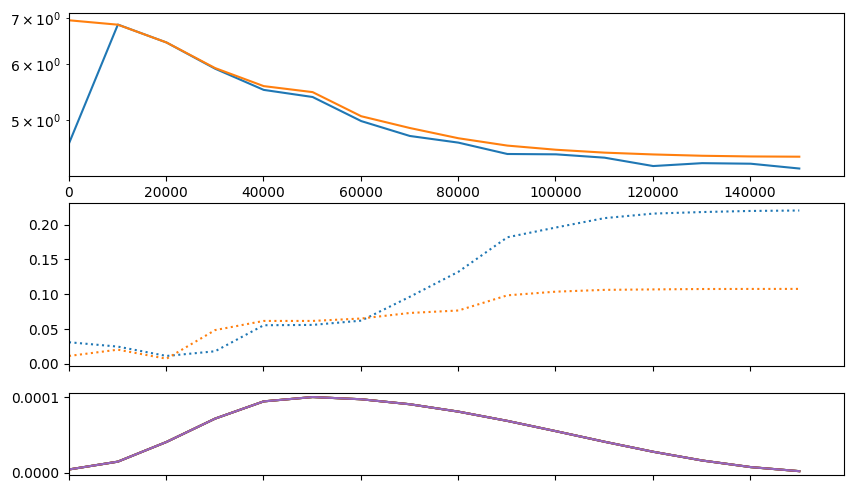

In [ ]:
model = make_model('micro', quantizers=2, dataset=train_ds_1200).cuda()
train("sadelar-up", model, train_ds_1200, val_ds, half=True, bs=64, lr=1e-4, epochs=1,
      table_row_every_iters=50000, run_valid_every_iters=10000, visual_class=CMLMVisual)

You can easily convert a Lightning checkpoint into an inference model:

In [ ]:
model = make_model('base', quantizers=2, dataset=train_ds).load_checkpoint('s2a_delar_mup-epoch=0-step=219500-val_loss=2.74.ckpt')

In [ ]:
model.save_model('s2a_up.model')

In [ ]:
SADelARTransformer.load_model(local_filename='s2a_up.model')

SADelARTransformer(
  (speaker_embedding): Embedding(7439, 512)
  (semantic_embedding): Embedding(1025, 512)
  (encoder): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): QueryHead(in_features=512, out_features=512, bias=True)
        (key): Linear(in_features=512, out_features=512, bias=False)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (out): Linear(in_features=512, out_features=512, bias=True)
      )
      (attn_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (mlp_ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): QueryHead(in_features=512, out_features=512, bias=True)
        (key): Line

In [ ]:
# the model files contain the weights and all the crucial hyperparameters
torch.load('s2a_up.model')

{'config': {'depth': 6,
  'ctx_n': 2250,
  'n_head': 8,
  'head_width': 64,
  'quantizers': 2,
  'speaker_map': {'2975': 0,
   '859': 1,
   '4518': 2,
   '2883': 3,
   '1347': 4,
   '449': 5,
   '1973': 6,
   '1353': 7,
   '370': 8,
   '362': 9,
   '3148': 10,
   '5107': 11,
   '1702': 12,
   '4191': 13,
   '2569': 14,
   '1780': 15,
   '342': 16,
   '829': 17,
   '971': 18,
   '1844': 19,
   '1289': 20,
   '5724': 21,
   '3467': 22,
   '1767': 23,
   '4293': 24,
   '1323': 25,
   '2382': 26,
   '1246': 27,
   '3119': 28,
   '4528': 29,
   '1327': 30,
   '4510': 31,
   '2849': 32,
   '822': 33,
   '3433': 34,
   '4256': 35,
   '535': 36,
   '261': 37,
   '2846': 38,
   '10289': 39,
   '386': 40,
   '612': 41,
   '455': 42,
   '1100': 43,
   '3372': 44,
   '4015': 45,
   '3361': 46,
   '199': 47,
   '1200': 48,
   '874': 49,
   '1737': 50,
   '2407': 51,
   '3318': 52,
   '271': 53,
   '3470': 54,
   '2691': 55,
   '3587': 56,
   '2109': 57,
   '104': 58,
   '2327': 59,
   '4080': 60,
 